In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import shapefile
import pyproj


#! /usr/bin/env python3

# data libraries
import sys
import os
import datetime as dt  # Python standard library datetime  module
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from netCDF4 import Dataset,num2date  # http://code.google.com/p/netcdf4-python/
import pandas as pd
import geopandas as gpd
from pyproj import Proj, transform
from matplotlib.path import Path

# plotting libraries
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.style as style
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point 
import cartopy.mpl.ticker as cticker
import glob
import array

In [4]:
def getPolyCoords(row, geom, coord_type):
    """
    Returns the coordinates ('x|y') of edges/vertices of a Polygon/others
    Args:
    - row: the row object from a geodataframe; i.e.   df.loc[1]
    - geom: the name of "geometry" column, usually "geometry"
    - coord_type: 'x', or 'y'
    ...
    Valid geometrie types 'Polygon', 'Point', 'LineString', 'MultiLineString', 'MultiPolygon'
    """

    # Parse the geometries and grab the coordinate
    geometry = row[geom]
    #print(geometry.type)

    if geometry.type=='Polygon':
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            # Interior is more complex: xxx.interiors[0].coords.xy[0]
            return list( geometry.exterior.coords.xy[0] )
        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return list( geometry.exterior.coords.xy[1] )

    if geometry.type in ['Point', 'LineString']:
        if coord_type == 'x':
            return list( geometry.xy[0] )
        elif coord_type == 'y':
            return list( geometry.xy[1] )

    if geometry.type=='MultiLineString':
        all_xy = []
        # updated code, using .geoms
        for ea in geometry.geoms:
            if coord_type == 'x':
                all_xy.append(list( ea.xy[0] ))
            elif coord_type == 'y':
                all_xy.append(list( ea.xy[1] ))
        return all_xy

    if geometry.type=='MultiPolygon':
        all_xy = []
        for ea in geometry.geoms:
            if coord_type == 'x':
                all_xy.append(list( ea.exterior.coords.xy[0] ))
            elif coord_type == 'y':
                all_xy.append(list( ea.exterior.coords.xy[1] ))
        return all_xy

    else:
        # Finally, return empty list for unknown geometries
        return []

In [5]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/monthly_shelves.pkl', 'rb') as f:
    monthly_shelves = pickle.load(f)

In [6]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/yearly_shelves.pkl', 'rb') as f:
    yearly_shelves = pickle.load(f)

In [7]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/seasonal_shelves.pkl', 'rb') as f:
    seasonal_shelves = pickle.load(f)

In [8]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/reanalysis_monthly.pkl', 'rb') as f:
    reanalysis_monthly = pickle.load(f)

In [9]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/reanalysis_yearly.pkl', 'rb') as f:
    reanalysis_yearly = pickle.load(f)

In [10]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/reanalysis_seasonal.pkl', 'rb') as f:
    reanalysis_seasonal = pickle.load(f)

In [34]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/bias_analysis_yearly.pkl', 'rb') as f:
    bias_analysis_yearly = pickle.load(f)
    
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/bias_analysis_seasonal.pkl', 'rb') as f:
    bias_analysis_seasonal = pickle.load(f)

In [35]:
bias_analysis_seasonal

{'Abbot':          Model Names  Mean Bias
 0         NorESM2-MM   1.288407
 1           E3SM-1-1   3.492754
 2         CAS-ESM2-0   4.780314
 3          KIOST-ESM   2.545258
 4       E3SM-1-1-ECA   3.329053
 5       E3SM-Project   3.425296
 6        CAMS-CSM1-0   3.870945
 7      MPI-ESM1-2-HR  -0.173157
 8          INM-CM4-8   3.931937
 9          INM-CM5-0   3.429746
 10       FGOALS-f3-L   1.215799
 11     AWI-CM-1-1-MR  -1.313157
 12     MPI-ESM1-2-LR   0.071154
 13           TaiESM1  -2.599188
 14      CMCC-CM2-SR5   1.719546
 15         CMCC-ESM2   1.791622
 16      IPSL-CM6A-LR   0.209606
 17         EC-Earth3   4.618488
 18          IITM-ESM   6.979115
 19         FGOALS-g3  -2.862908
 20     ACCESS-ESM1-5  -0.423530
 21        NorESM2-LM   1.374054
 22         ACESS-CM2   0.359464
 23         GFDL-ESM4   0.120922
 24     EC-Earth3-Veg   4.895111
 25  EC-Earth3-Veg-LR   4.447593
 26             NESM3   0.839421
 27        MRI-ESM2-0   0.132430
 28           CanESM5  -1.164244
 

In [36]:
bias_analysis_yearly

{'Abbot':          Model Names  Mean Bias
 0         NorESM2-MM  -1.920616
 1           E3SM-1-1   1.104608
 2         CAS-ESM2-0   2.461220
 3          KIOST-ESM   4.559068
 4       E3SM-1-1-ECA   0.818141
 5       E3SM-Project   1.154275
 6        CAMS-CSM1-0   1.669094
 7      MPI-ESM1-2-HR  -0.115290
 8          INM-CM4-8   2.961474
 9          INM-CM5-0   2.426538
 10       FGOALS-f3-L  -1.254382
 11     AWI-CM-1-1-MR  -1.904469
 12     MPI-ESM1-2-LR   0.429804
 13           TaiESM1  -5.321476
 14      CMCC-CM2-SR5  -3.071861
 15         CMCC-ESM2  -2.727570
 16      IPSL-CM6A-LR  -2.233295
 17         EC-Earth3   2.788666
 18          IITM-ESM   6.184594
 19         FGOALS-g3  -5.174135
 20     ACCESS-ESM1-5  -1.068254
 21        NorESM2-LM  -1.510909
 22         ACESS-CM2  -2.330131
 23         GFDL-ESM4  -1.314581
 24     EC-Earth3-Veg   2.686422
 25  EC-Earth3-Veg-LR   2.875686
 26             NESM3   1.990793
 27        MRI-ESM2-0  -2.031476
 28           CanESM5  -3.542048
 

In [12]:
f1 = plt.figure(1,figsize=(15,12))
plt.xlabel("Time (Years)", fontsize = 18)
plt.ylabel(r"Annual Surface Temperature ($\degree$ C)", fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(1959,2100)

for key in yearly_shelves:
    for i in range(len(yearly_shelves[key])):
    plt.plot(yearly_shelves[key]['year'][i],yearly_shelves[key]['temp spatial average'][i],label = '_nolegend_', color= 'lightgray')
plt.plot(yearly_reanalysis[key]['year'][0],yearly_reanalysis[key]['temp spatial average'][0],c = 'blue')



IndentationError: expected an indented block after 'for' statement on line 9 (3403131935.py, line 10)

### Bias Analysis for the Shelves 

A function that takes in the temperature from both the models and the ERA5 data and produces a plot with a bias analysis, a dataframe with the stored data, and a dataframe sorted by bias. 

#### Inputs
- shelf_name: Any shelf name from the dataframes read in to the script
- type_of_analysis: The type of analysis is eithre 'yearly' or 'seasonal'

#### Outputs
- f2: bar plot of bias for each CMIP6 model and the mean of the models. This bias is calculated by subtracting the ERA5 temperatures from the model temperatures across the timescale. The bias for eachmodel is produced by taking the mean of that variation. The mean of the CMIP6 models is calculated by taking the mean of the temperature at each time step and then performing the variation as mentioned above. 
- df_sortted: the dataframe of the CMIP6 models and their overall bias assigned based off of the ERA5 data in a dataframe sortted based on bias from negative to positive bias. The smallest bias will be towards the middle of the dataframe. 
- df_sortted: the dataframe of the CMIP6 models and their overall bias assigned based off of the ERA5 data in a dataframe 

In [11]:
def bias_analysis_shelf(shelf_name,type_of_analysis):
    
    if type_of_analysis == 'yearly':
        shelf = yearly_shelves[shelf_name]
        shelf_reanalysis = yearly_reanalysis[shelf_name]
        
        shelf_cropped = np.zeros((len(shelf['year']),len(shelf['year'][0][110:172])))
        shelf_cropped_temp = np.zeros((len(shelf['year']),len(shelf['year'][0][110:172]),len(shelf['original latitude'][0]),len(shelf['original longitude'][0])))
        shelf_cropped_temp_spatial_avg = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][110:172])))
        
        for i in range(len(shelf['year'])):
            shelf_cropped[i] = shelf['year'][i][110:172]
            shelf_cropped_temp[i] = shelf['temp'][i][110:172]
            shelf_cropped_temp_spatial_avg[i] = shelf['temp spatial average'][i][110:172]
        
        model_names = list(shelf['Model'])
        
        models_mean = np.mean(shelf_cropped_temp_spatial_avg,axis=0)
        model_names.append('Model Mean')
        
        
        shelf_cropped_temp_spatial_avg[-1]= models_mean
        
        
        variation = shelf_cropped_temp_spatial_avg - shelf_reanalysis['temp spatial average'][0][0:-1]
        mean_bias = np.mean(variation,axis=1)
        

        #Making data frame for bias analysis
        df = pd.DataFrame(list(zip(model_names,mean_bias)),columns=['Model Names','Mean Bias'])

        
        df_sortted = df.sort_values("Mean Bias",ascending=False)

        x = df_sortted['Model Names']
        y = df_sortted['Mean Bias']

        cmap = plt.cm.seismic
        norm = cm.colors.TwoSlopeNorm(vcenter=0,vmin=np.min(y),vmax=np.max(y))

        f2 = fig, ax = plt.subplots(figsize=(15,12))
        bars = ax.barh(x,y,align='center',color=cmap(norm(y.values)))
        ax.bar_label(bars,fmt = '%1.2f',padding=2,label_type='edge',fontsize=14)
        ax.set_xlim(left=min(y)-1)
        ax.set_xlabel(r"Mean Yearly Temperature Bias($\degree$ C)", fontsize = 18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        
        my_path = '/raid01/mafields/tas/MODELS_filtered/ssp585/figures/bias/shelves_yearly/' # Figures out the absolute path for you in case your working directory moves around.
        my_file = shelf_name + '_yearly_bias.png'
   
        plt.savefig(os.path.join(my_path, my_file))
        plt.close()
    
    else: 
        shelf = seasonal_shelves[shelf_name]
        shelf_reanalysis = seasonal_reanalysis[shelf_name]
        
        shelf_cropped = np.zeros((len(shelf['year']),len(shelf['year'][0][109:172])))
        shelf_cropped_temp = np.zeros((len(shelf['year']),len(shelf['year'][0][109:172]),len(shelf['original latitude'][0]),len(shelf['original longitude'][0])))
        shelf_cropped_temp_spatial_avg = np.zeros((len(shelf['year'])+1,len(shelf['year'][0][109:172])))

        for i in range(len(shelf['year'])):
            shelf_cropped[i] = shelf['year'][i][109:172]
            shelf_cropped_temp[i] = shelf['temp'][i][109:172]
            shelf_cropped_temp_spatial_avg[i] = shelf['temp spatial average'][i][109:172]
            
        model_names = list(shelf['Model'])
        
        models_mean = np.mean(shelf_cropped_temp_spatial_avg,axis=0)
        model_names.append('Model Mean')
        
        
        shelf_cropped_temp_spatial_avg[-1]= models_mean
        
        variation = shelf_cropped_temp_spatial_avg - shelf_reanalysis['temp spatial average'][0][0:-1]
        mean_bias = np.mean(variation,axis=1)
        

        #Making data frame for bias analysis
        df = pd.DataFrame(list(zip(model_names,mean_bias)),columns=['Model Names','Mean Bias'])

        df_sortted = df.sort_values("Mean Bias",ascending=False)

        x = df_sortted['Model Names']
        y = df_sortted['Mean Bias']

        cmap = plt.cm.seismic
        norm = cm.colors.TwoSlopeNorm(vcenter=0,vmin=np.min(y),vmax=np.max(y))


        f2 = fig, ax = plt.subplots(figsize=(15,12))
        bars = ax.barh(x,y,align='center',color=cmap(norm(y.values)))
        ax.bar_label(bars,fmt = '%1.2f',padding=2,label_type='edge',fontsize=14)
        ax.set_xlim(left=min(y)-1)
        ax.set_xlabel(r"Mean Seasonal Temperature Bias($\degree$ C)", fontsize = 18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        
        my_path = '/raid01/mafields/tas/MODELS_filtered/ssp585/figures/bias/shelves_seasonal/' # Figures out the absolute path for you in case your working directory moves around.
        my_file = shelf_name + '_seasonal_bias.png'
   
        plt.savefig(os.path.join(my_path, my_file))
        plt.close()

    return f2, df, df_sortted

In [12]:
def iceshelf_dictionary(dictionary,type_of_analysis):

    for key in dictionary:    
        shelf_plot, df_shelf, df_shelf_sortted = bias_analysis_shelf(key,type_of_analysis)
        #if type_of_analysis == 'seasonal':
            #bias_analysis_seasonal[key] = df_shelf
            #print(key)
        #elif type_of_analysis == 'yearly':
            #bias_analysis_yearly[key] = df_shelf
            #print(key)
            
    task = 'completed task'
                
    return task

In [19]:
def iceshelf_gridsize(dictionary,type_of_analysis):
    
    gridsize_shelves = {}
    
    for key in dictionary:    
        if type_of_analysis == 'seasonal':
            shelf_gridsize = seasonal_shelves[key]['cropped lat'][0].size
            gridsize_shelves[key] = shelf_gridsize
    
        elif type_of_analysis == 'yearly':
            shelf_gridsize = yearly_shelves[key]['cropped lat'][0].size
            gridsize_shelves[key] = shelf_gridsize
                
    return gridsize_shelves

In [20]:
gridsize_shelves = iceshelf_gridsize(yearly_shelves,'yearly')

total_shelf_weights = {}

for key in gridsize_shelves: 
    total_shelf_weights[key] = gridsize_shelves[key]/sum(gridsize_shelves.values())

print(total_shelf_weights)


{'Abbot': 0.014717990942774805, 'Amery': 0.024392754219843556, 'Atka': 0.0009263071222725401, 'Baudouin': 0.012762453684643887, 'Borchgrevink': 0.008645533141210375, 'Brunt Stancomb': 0.01914368052696583, 'Conger Glenzer': 0.0004116920543433512, 'Cook': 0.0012350761630300535, 'Cosgrove': 0.0011321531494442158, 'Crosson': 0.001543845203787567, 'Dotson': 0.003087690407575134, 'Drygalski': 0.0008233841086867024, 'Ekstrom': 0.002470152326060107, 'Filchner': 0.0838822560724578, 'Fimbul': 0.016158913132976533, 'George VI': 0.01029230135858378, 'Getz': 0.0168793742280774, 'Holmes': 0.0008233841086867024, 'Jelbart': 0.004322766570605188, 'Land': 0.0003087690407575134, 'LarsenB': 0.0006175380815150268, 'LarsenC': 0.016158913132976533, 'LarsenD': 0.009983532317826265, 'Lazarev': 0.0036023054755043226, 'Mariner': 0.001440922190201729, 'Mertz': 0.001955537258130918, 'Moscow University': 0.001543845203787567, 'Nansen': 0.0009263071222725401, 'Nickerson': 0.004013997529847674, 'Nivl': 0.002778921366

In [21]:
east_shelves_gridsize = {}
east_shelves_gridsize.update({'Amery':gridsize_shelves['Amery'],'Atka':gridsize_shelves['Atka'],'Baudouin':gridsize_shelves['Baudouin'],
                             'Borchgrevink':gridsize_shelves['Borchgrevink'],'Conger Glenzer':gridsize_shelves['Conger Glenzer'],
                             'Cook':gridsize_shelves['Cook'],'Drygalski':gridsize_shelves['Drygalski'],'Fimbul':gridsize_shelves['Fimbul'],'Holmes':gridsize_shelves['Holmes'],
                             'Lazarev':gridsize_shelves['Lazarev'],'Mariner':gridsize_shelves['Mariner'],'Mertz':gridsize_shelves['Mertz'],'Moscow University':gridsize_shelves['Moscow University'],'Nansen':gridsize_shelves['Nansen']
                             ,'Nivl':gridsize_shelves['Nivl'],'Prince Harald':gridsize_shelves['Prince Harald'],'Rennick':gridsize_shelves['Rennick'],'Ross East':gridsize_shelves['Ross East'],'Shackleton':gridsize_shelves['Shackleton'],
                             'Totten':gridsize_shelves['Totten'],'Vigrid':gridsize_shelves['Vigrid'],'West':gridsize_shelves['West']})

east_shelf_weights = {}

for key in east_shelves_gridsize: 
    east_shelf_weights[key] = east_shelves_gridsize[key]/sum(east_shelves_gridsize.values())

print(east_shelf_weights)



west_shelves_gridsize = {}
west_shelves_gridsize.update({'Abbot':gridsize_shelves['Abbot'],'Brunt Stancomb':gridsize_shelves['Brunt Stancomb'],
                             'Cosgrove':gridsize_shelves['Cosgrove'],'Crosson':gridsize_shelves['Crosson'],
                             'Dotson':gridsize_shelves['Dotson'],'Ekstrom':gridsize_shelves['Ekstrom'],'Filchner':gridsize_shelves['Filchner'],'George VI':gridsize_shelves['George VI'],
                             'Getz':gridsize_shelves['Getz'],'Jelbart':gridsize_shelves['Jelbart'],'Land':gridsize_shelves['Land'],'LarsenB':gridsize_shelves['LarsenB'],'LarsenC':gridsize_shelves['LarsenC'],'LarsenD':gridsize_shelves['LarsenD'],'Nickerson':gridsize_shelves['Nickerson']
                             ,'pine island':gridsize_shelves['pine island'],'Quar':gridsize_shelves['Quar'],'Riiser-Larsen':gridsize_shelves['Riiser-Larsen'],'Ronne':gridsize_shelves['Ronne'],'Ross West':gridsize_shelves['Ross West'],
                             'Stange':gridsize_shelves['Stange'],'Sulzberger':gridsize_shelves['Sulzberger'],'Thwaites':gridsize_shelves['Thwaites'],'Venable':gridsize_shelves['Venable'],
                             'Withrow':gridsize_shelves['Withrow']})



west_shelf_weights = {}

for key in west_shelves_gridsize: 
    west_shelf_weights[key] = west_shelves_gridsize[key]/sum(west_shelves_gridsize.values())

print(west_shelf_weights)

{'Amery': 0.09375, 'Atka': 0.003560126582278481, 'Baudouin': 0.0490506329113924, 'Borchgrevink': 0.03322784810126582, 'Conger Glenzer': 0.0015822784810126582, 'Cook': 0.004746835443037975, 'Drygalski': 0.0031645569620253164, 'Fimbul': 0.06210443037974683, 'Holmes': 0.0031645569620253164, 'Lazarev': 0.013844936708860759, 'Mariner': 0.005537974683544304, 'Mertz': 0.007515822784810127, 'Moscow University': 0.005933544303797469, 'Nansen': 0.003560126582278481, 'Nivl': 0.010680379746835443, 'Prince Harald': 0.0011867088607594937, 'Rennick': 0.005142405063291139, 'Ross East': 0.6257911392405063, 'Shackleton': 0.03441455696202532, 'Totten': 0.008306962025316455, 'Vigrid': 0.001977848101265823, 'West': 0.021756329113924052}
{'Abbot': 0.019894268224819142, 'Brunt Stancomb': 0.02587646076794658, 'Cosgrove': 0.001530328324986088, 'Crosson': 0.002086811352253756, 'Dotson': 0.004173622704507512, 'Ekstrom': 0.00333889816360601, 'Filchner': 0.11338341680578742, 'George VI': 0.013912075681691708, 'Get

In [22]:
def grouping_bias_analysis(dictionary,weights):
    
    applied_weights = {}
    
    for key in dictionary:
        weighted_bias = dictionary[key]['Mean Bias'] * weights[key]
        df = pd.concat([dictionary[key]['Model Names'], weighted_bias], axis=1)
        applied_weights[key] = df
        
    return applied_weights


In [23]:
def grouping_bias_analysis_selection(dictionary,weights):
    
    applied_weights = {}
    
    for key in weights:
        weighted_bias = dictionary[key]['Mean Bias'] * weights[key]
        df = pd.concat([dictionary[key]['Model Names'], weighted_bias], axis=1)
        applied_weights[key] = df
        
    return applied_weights

In [37]:
applied_weights_all_shelves_yearly = grouping_bias_analysis(bias_analysis_yearly,total_shelf_weights)
applied_weights_all_shelves_seasonal = grouping_bias_analysis(bias_analysis_seasonal,total_shelf_weights)

In [20]:
applied_weights_east_shelves_yearly = grouping_bias_analysis_selection(bias_analysis_yearly,east_shelf_weights)
applied_weights_east_shelves_seasonal = grouping_bias_analysis_selection(bias_analysis_seasonal,east_shelf_weights)

In [21]:
applied_weights_west_shelves_yearly = grouping_bias_analysis_selection(bias_analysis_yearly,west_shelf_weights)
applied_weights_west_shelves_seasonal = grouping_bias_analysis_selection(bias_analysis_seasonal,west_shelf_weights)

In [1]:
def creating_model_bias_dict_and_plot(dictionary):   
    model_bias = list()
    names = list()

    for i in range(len(bias_analysis_yearly['Abbot'])):
        values = np.zeros(len(dictionary))
        model_name = bias_analysis_yearly['Abbot']['Model Names'][i]
        names.append(model_name)

        k = 0
        for key in dictionary:
            x = dictionary[key]['Mean Bias'][i]
            values[k] = x
            k += 1

        weight = np.sum(values)
        model_bias.append(weight)

    df = pd.DataFrame(list(zip(names,model_bias)),columns=['Model Names','Weighted Mean Bias'])

    #with open('weighted_mean_bias_all_shelves_yearly.pkl', 'wb') as f:
       # pickle.dump(df,f)

    df_sortted = df.sort_values("Weighted Mean Bias",ascending=False)

    x = df_sortted['Model Names']
    y = df_sortted['Weighted Mean Bias']

    cmap = plt.cm.seismic
    norm = cm.colors.TwoSlopeNorm(vcenter=0,vmin=np.min(y),vmax=np.max(y))

    f2 = fig, ax = plt.subplots(figsize=(15,12))
    bars = ax.barh(x,y,align='center',color=cmap(norm(y.values)))
    ax.bar_label(bars,fmt = '%1.2f',padding=2,label_type='edge',fontsize=14)
    ax.set_xlim(left=min(y)-1)
    ax.set_xlabel(r"Mean Annual Austral Summer Temperature Bias($\degree$ C)", fontsize = 18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    my_path = '/raid01/mafields/tas/MODELS_filtered/ssp585/figures/bias/' # Figures out the absolute path for you in case your working directory moves around.
    my_file = 'weighted_yearly_bias_all_shelves.png'

    plt.savefig(os.path.join(my_path, my_file))
    
    return f2,df_sortted

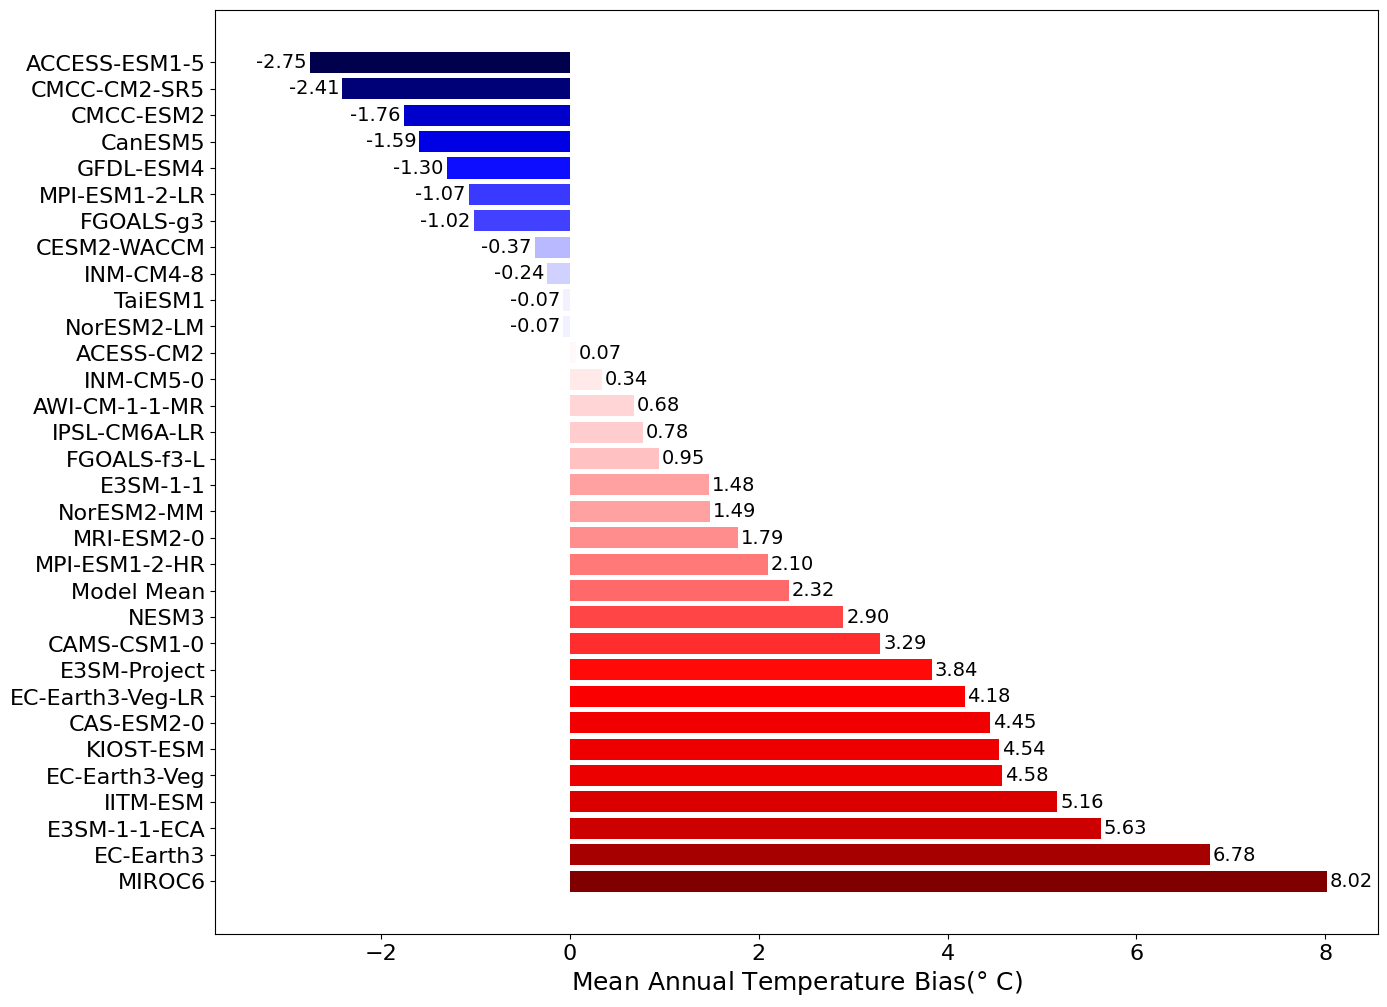

In [39]:
all_shelves_yearly_fig, weights_all_shelves_yearly_sortted = creating_model_bias_dict_and_plot(applied_weights_all_shelves_yearly)

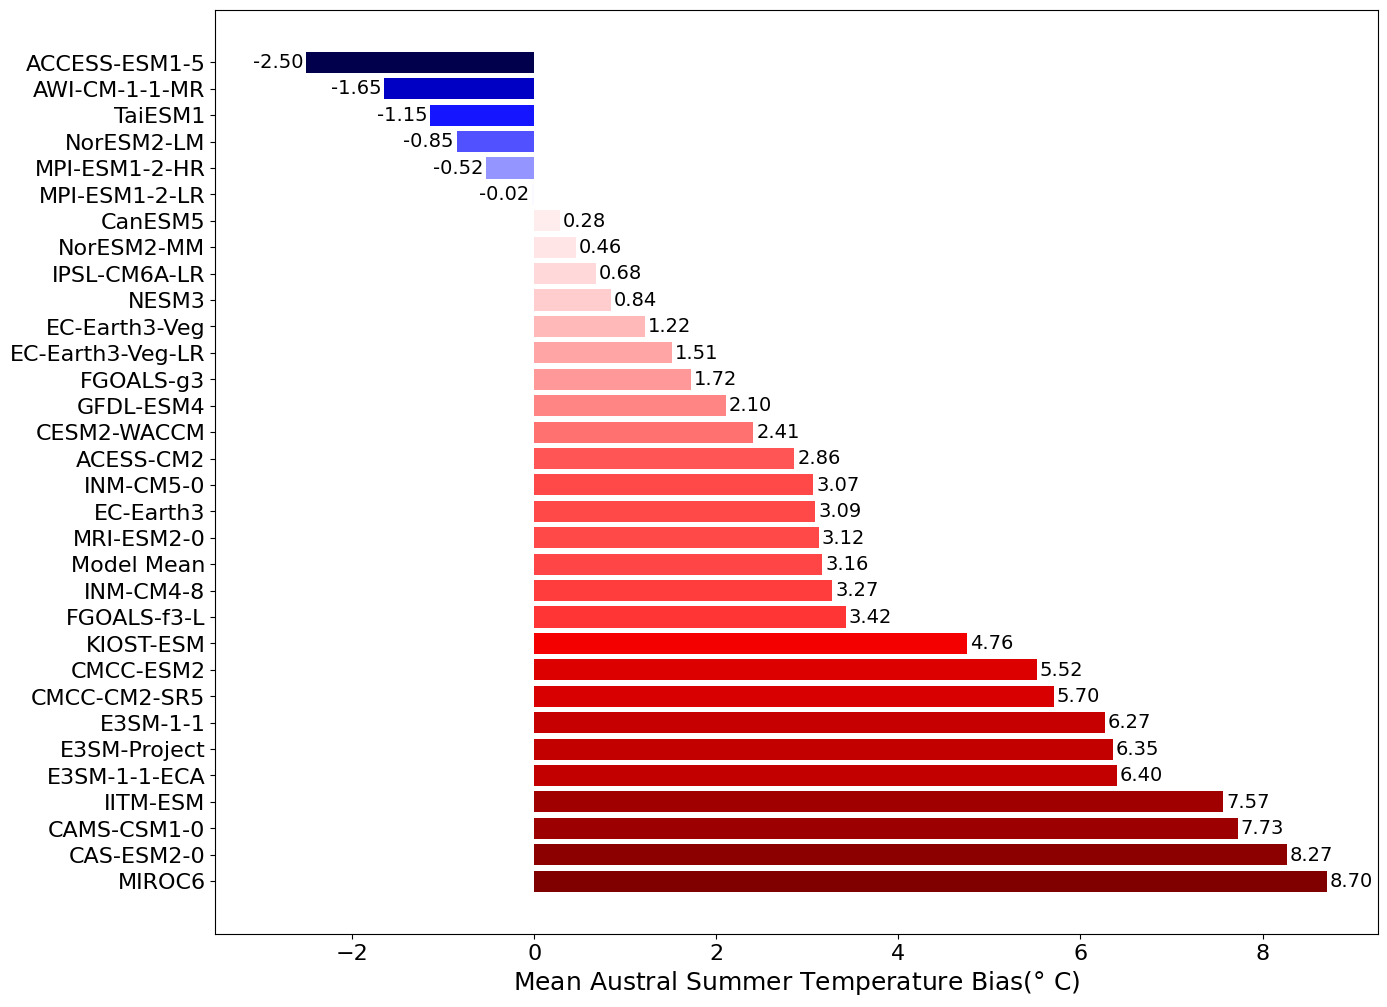

In [41]:
all_shelves_seasonal_fig, weights_all_shelves_seasonal_sortted = creating_model_bias_dict_and_plot(applied_weights_all_shelves_seasonal)

In [66]:

def best_bias_per_shelf(dictionary):
    Model = list()
    Mean_Bias = list()
    keys = list()
    variation = list()

    for key in dictionary:

        #Storing Iceshelf Name
        keys.append(key)

        #Model with the lowest Bias
        bestbias = dictionary[key].iloc[(dictionary[key]['Mean Bias']-0).abs().argsort()[:1]]
        #index = bestbias.index.to_numpy()
        Model.append(bestbias['Model Names'].tolist())
        Mean_Bias.append(bestbias['Mean Bias'].tolist())

        #variation in the bias values
        max_bias = dictionary[key]['Mean Bias'].max()
        min_bias = dictionary[key]['Mean Bias'].min()
        variation.append(np.abs(max_bias-min_bias))

    df = pd.DataFrame(list(zip(keys,Model,Mean_Bias,variation)),columns=['Ice Shelf','Model','Bias','Bias Variation'])
    
    return df


    



In [79]:
yearly_best_bias_shelves

,Ice Shelf,Model,Bias,Bias Variation
0,Abbot,[MPI-ESM1-2-HR],[-0.08678931679579228],11.938030
1,Amery,[Model Mean],[-0.028805867689948125],13.186226
2,Atka,[AWI-CM-1-1-MR],[-0.032710250740874254],14.941959
3,Baudouin,[E3SM-1-1-ECA],[0.21057516540432747],14.559827
4,Borchgrevink,[E3SM-1-1-ECA],[0.23532036963608785],15.850095
5,Brunt Stancomb,[FGOALS-g3],[0.3309290360532459],12.351277
6,Conger Glenzer,[AWI-CM-1-1-MR],[-0.18928557268470314],11.887948
7,Cook,[NESM3],[-0.05583008939105861],12.640311
8,Cosgrove,[MPI-ESM1-2-LR],[0.26627672449344353],12.213788
9,Crosson,[CAMS-CSM1-0],[-0.07958058930478844],11.566781


<AxesSubplot: >

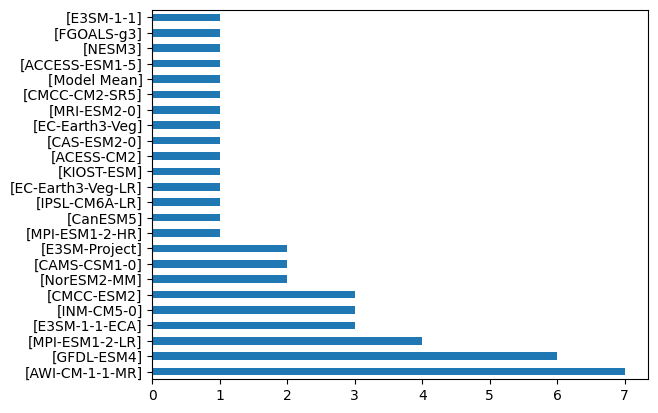

In [76]:
yearly_best_bias_shelves = best_bias_per_shelf(bias_analysis_yearly)


fig, ax = plt.subplots()
yearly_best_bias_shelves['Model'].value_counts().plot(ax=ax, kind='barh')

<AxesSubplot: >

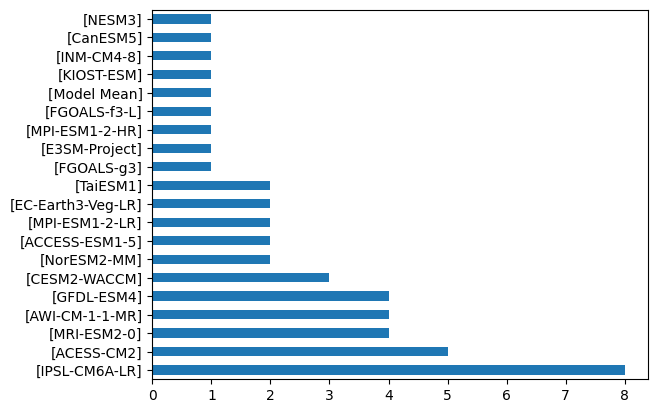

In [77]:
seasonal_best_bias_shelves = best_bias_per_shelf(bias_analysis_seasonal)

seasonal_best_bias_shelves

fig, ax = plt.subplots()
seasonal_best_bias_shelves['Model'].value_counts().plot(ax=ax, kind='barh')

### Seasonality Correlation

##### pearson correlation coefficient between monthly iceshelf data and the monthly ERA5 data



In [65]:
bestbias = bias_analysis_yearly['Abbot'].iloc[(bias_analysis_yearly[key]['Mean Bias']-0).abs().argsort()[:1]]
index = bestbias.index.to_numpy()
print(index)
print(bestbias['Model Names'].tolist())


[22]
['GFDL-ESM4']


### Plotting the Data from the Dataframes

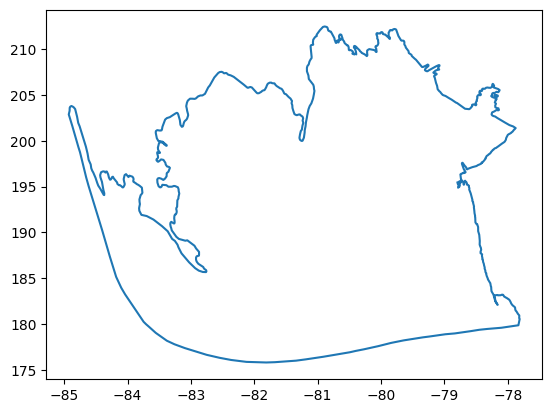

In [16]:
shelf = gpd.read_file('/raid01/mafields/tas/MODELS_filtered/ssp585/shape_files/Ross West.shp') 
shelf.crs = "EPSG:3031"
shelf = shelf.to_crs(epsg=4326)

shelf_lon = getPolyCoords(shelf.loc[0], 'geometry', 'x')

shelf_lon = np.array(shelf_lon)

shelf_lon_conversion_west = shelf_lon - 360*((shelf_lon)-np.abs(shelf_lon))/(2*np.abs(shelf_lon))

shelf_lat_west = getPolyCoords(shelf.loc[0], 'geometry', 'y')
shelf_list = np.vstack([shelf_lat_west,shelf_lon_conversion_west]).T
shelf_path = Path(shelf_list)

plt.plot(shelf_lat_west,shelf_lon_conversion_west)

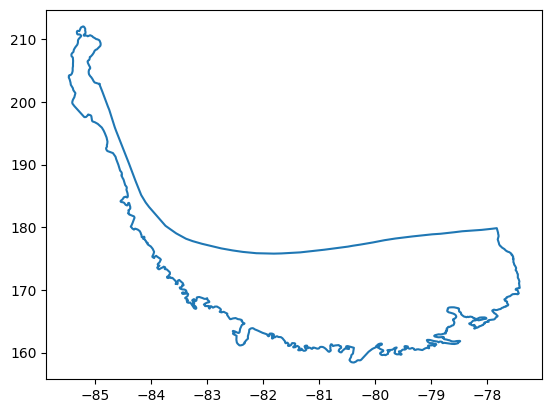

In [17]:
shelf = gpd.read_file('/raid01/mafields/tas/MODELS_filtered/ssp585/shape_files/Ross East.shp') 
shelf.crs = "EPSG:3031"
shelf = shelf.to_crs(epsg=4326)

shelf_lon = getPolyCoords(shelf.loc[0], 'geometry', 'x')

shelf_lon = np.array(shelf_lon)

shelf_lon_conversion_east = shelf_lon - 360*((shelf_lon)-np.abs(shelf_lon))/(2*np.abs(shelf_lon))

shelf_lat_east = getPolyCoords(shelf.loc[0], 'geometry', 'y')
shelf_list = np.vstack([shelf_lat_east,shelf_lon_conversion_east]).T
shelf_path = Path(shelf_list)

plt.plot(shelf_lat_east,shelf_lon_conversion_east)

In [13]:
Ross_East = yearly_reanalysis['Ross East']
Ross_West = yearly_reanalysis['Ross West']

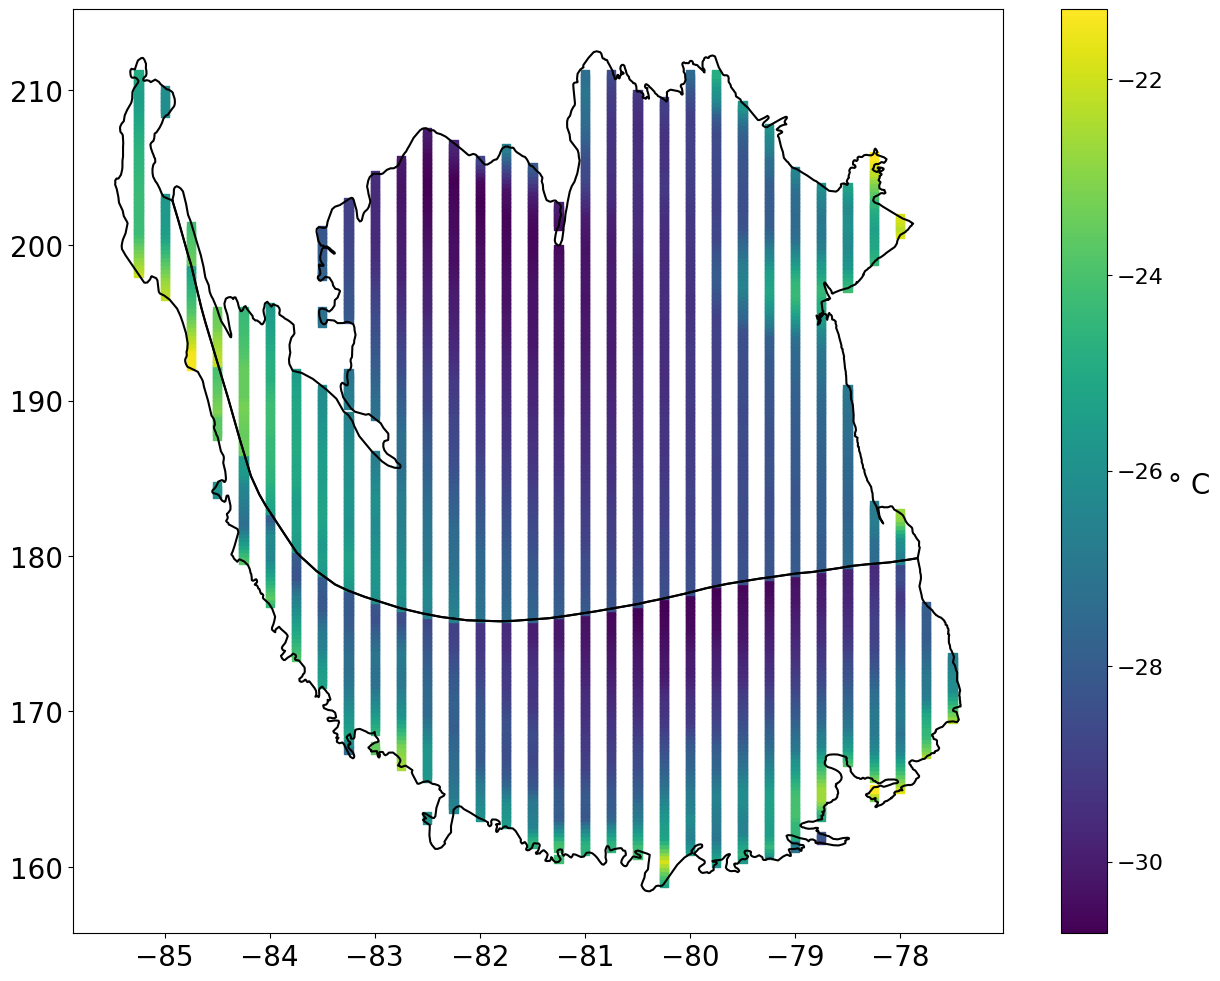

In [40]:
fig = plt.figure(figsize=(15,12))
plt.plot(shelf_lat_east,shelf_lon_conversion_east,c='k')
plt.plot(shelf_lat_west,shelf_lon_conversion_west,c='k')
plt.scatter(Ross_East['cropped lat'][0],Ross_East['cropped lon'][0],c = Ross_East['cropped temp'][0][0],marker = 's')
plt.scatter(Ross_West['cropped lat'][0],Ross_West['cropped lon'][0],c = Ross_West['cropped temp'][0][0],marker = 's')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
cb = plt.colorbar(orientation="vertical")
cb.set_label(r' $\degree$ C',size=20,rotation=0,labelpad=15)
cb.ax.tick_params(labelsize=16)

In [19]:
east_yearly_sortted
for key in applied_weights_all_shelves_yearly:    
    lst = applied_weights_all_shelves_yearly[key]
    df_closest = lst.iloc[(lst['Mean Bias']-0).abs().argsort()[:1]]
    print(key,df_closest)

NameError: name 'east_yearly_sortted' is not defined